In [1]:
#! pip install tinkoff-investments

In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tinkoff.invest import Client, InstrumentIdType
from tinkoff.invest.schemas import CandleInterval
from tinkoff.invest.services import InstrumentsService
from datetime import datetime
from scipy.optimize import minimize
import tabulate
import scipy as sp

import seaborn as sns
sns.set(style="darkgrid")

# Информация по портфелю

In [ ]:
# Токен для портфеля (только чтение)
token_portfolio = ""
potfolio_id     = ""

In [ ]:
assets = ["Первая – Фонд Топ Российских акций",
          "ВИМ Фонд Золото",
          "Тинькофф BuyBack Leaders",
          "Тинькофф Eurostocks",
          "Первая – Фонд Корпоративные облигации"
          ]

# Загрузка данных для портфеля с сайта брокера

In [ ]:
def cast_money(v):
    """
    param: v MoneyValue object
    return:  сумма в стандартном виде

    Денежная сумма в определенной валюте
    Field 	  |  Type 	|   Description
    ----------------------------------------------
    currency  |	string 	|   Строковый ISO-код валюты
    units 	  |  int64 	|   Целая часть суммы, может быть отрицательным числом
    nano 	  |  int32 	|   Дробная часть суммы, может быть отрицательным числом

    https://tinkoff.github.io/investAPI/common/#moneyvalue

    """
    return v.units + v.nano / 1e9

In [ ]:
# получени информации об портфеле
with Client(token_portfolio) as client:

    r = client.operations.get_portfolio(account_id=potfolio_id)

    portfolio = pd.DataFrame([{
        'figi':              p.figi,
        'instrument_type':   p.instrument_type,
        'quantity':          int(p.quantity.units),
        'expected_yield':    float(p.expected_yield.units),
        'average_buy_price': cast_money(p.average_position_price),
        'currency':          p.average_position_price.currency
    } for p in r.positions])

In [ ]:
# выборка только etf фондов потфеля
portfolio_etf = portfolio[portfolio.instrument_type == 'etf']

pd.options.mode.chained_assignment = None

# добавление колонки с названиями фондов
with Client(token_portfolio) as client:
    l = []
    instruments: InstrumentsService = client.instruments
    for fig in portfolio_etf.figi:
        l += [instruments.etf_by(id_type=InstrumentIdType.INSTRUMENT_ID_TYPE_FIGI, id=fig).instrument.name]

portfolio_etf.loc[:, "name"] = l
portfolio_etf

,figi,instrument_type,quantity,expected_yield,average_buy_price,currency,name
0,BBG00M0C8YM7,etf,100,4.0,17.620,rub,Первая – Фонд Топ Российских акций
3,BBG005HLSZ23,etf,34,99.0,52.380,rub,FinEx Акции американских компаний
5,BBG00V9V16J8,etf,880,-27.0,1.501,rub,ВИМ Фонд Золото
6,TCS10A103VL1,etf,200,-57.0,8.610,rub,Тинькофф BuyBack Leaders
10,TCS10A103VE6,etf,172,-61.0,9.940,rub,Тинькофф Eurostocks
11,BBG00NTZWLM4,etf,2,172.0,1634.200,rub,Первая – Фонд Американские акции
12,BBG00Y6D0N45,etf,91,-6.0,1.154,usd,FinEx Акции компаний IT-сектора США
13,TCS00A100P44,etf,59,-2.0,13.105,rub,Первая – Фонд Корпоративные облигации


In [ ]:
# далее рассматриваем только те активы, в которые инвестируем
portfolio_etf = portfolio_etf[portfolio_etf.name.apply(lambda x: x in assets)]

In [ ]:
def create_df(candels):
    """
    param: candels  array of HistoricCandle
    return та же структура, только в виде pd.DataFrame 

    Информация о свече.
    https://tinkoff.github.io/investAPI/marketdata/#historiccandle
    
    """
    df = pd.DataFrame([{
        'time':    c.time,
        'volume':  c.volume,
        'open':    cast_money(c.open),
        'close':   cast_money(c.close),
        'high':    cast_money(c.high),
        'low':     cast_money(c.low)
    } for c in candels])
    return df

In [ ]:
# даты, за которые рассматриваю котировки фондов
start = datetime(2020, 7, 1)
end   = datetime.utcnow()

# загрузка исторических данных по котировкам фондов
with Client(token_portfolio) as client:
    ans_df = None 
    for figi in portfolio_etf.figi:
        r0 = client.get_all_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=CandleInterval.CANDLE_INTERVAL_DAY
        )
        
        candles = np.array(list(r0))
        
        if candles.size > 0:
            tmp = create_df(candles)[["time", "close"]]
        else:
            tmp = pd.DataFrame([], columns=["time", "close"])
        tmp.columns = ["time", f"close_{figi}"]

        if ans_df is None:
            ans_df = tmp.copy()
        else:
            ans_df = ans_df.merge(tmp, how='outer', on='time')

ans_df.columns = np.insert(np.array(portfolio_etf.figi), [0], ['time'])
ans_df = ans_df.sort_values("time")    
ans_df = ans_df.reset_index(drop=True)
ans_df

,time,BBG00M0C8YM7,BBG00V9V16J8,TCS10A103VL1,TCS10A103VE6,TCS00A100P44
0,2020-06-30 07:00:00+00:00,12.835,NaN,NaN,NaN,10.904
1,2020-07-02 07:00:00+00:00,12.980,NaN,NaN,NaN,10.870
2,2020-07-03 07:00:00+00:00,13.065,NaN,NaN,NaN,10.894
3,2020-07-06 07:00:00+00:00,13.210,NaN,NaN,NaN,10.910
4,2020-07-07 07:00:00+00:00,13.190,NaN,NaN,NaN,10.908
...,...,...,...,...,...,...
769,2023-08-14 07:00:00+00:00,17.800,1.5350,9.07,10.43,13.034
770,2023-08-15 07:00:00+00:00,17.739,1.5190,8.87,10.20,12.979
771,2023-08-16 07:00:00+00:00,17.312,1.4680,8.63,9.91,12.974
772,2023-08-17 07:00:00+00:00,17.466,1.4785,8.45,9.66,13.065


In [ ]:
ans_df.isna().sum()

time              0
BBG00M0C8YM7      4
BBG00V9V16J8     14
TCS10A103VL1    421
TCS10A103VE6    449
TCS00A100P44      5
dtype: int64

In [ ]:
# заполнение отсутствующих значений на среднее по колонке
for col in ans_df.columns[1:]:
    # крание значения диапазона в случае отсутствия заполняю средним
    if ans_df.shape[0] - 1 in ans_df.loc[ans_df[col].isna(), col].index:
        ans_df.loc[ans_df.shape[0]- 1, col] = ans_df[col].mean()
    
    if 0 in ans_df.loc[ans_df[col].isna(), col].index:
        ans_df.loc[0, col] = ans_df[col].mean()
    
    # промежуточные значения линейно интерполирую
    f = sp.interpolate.interp1d(ans_df.index[ans_df.notnull().loc[:,col]], ans_df.loc[ans_df.notnull().loc[:, col], col])
    ans_df.loc[ans_df[col].isna(), col] = f(ans_df.index[ans_df.isna().loc[:,col]])
# переименование колонок на название фондов
ans_df.columns = np.insert(np.array(portfolio_etf.name), [0], ['time'])
ans_df

,time,Первая – Фонд Топ Российских акций,ВИМ Фонд Золото,Тинькофф BuyBack Leaders,Тинькофф Eurostocks,Первая – Фонд Корпоративные облигации
0,2020-06-30 07:00:00+00:00,12.835,1.123413,6.225703,6.884951,10.904
1,2020-07-02 07:00:00+00:00,12.980,1.121871,6.228059,6.888723,10.870
2,2020-07-03 07:00:00+00:00,13.065,1.120330,6.230415,6.892494,10.894
3,2020-07-06 07:00:00+00:00,13.210,1.118789,6.232772,6.896266,10.910
4,2020-07-07 07:00:00+00:00,13.190,1.117248,6.235128,6.900038,10.908
...,...,...,...,...,...,...
769,2023-08-14 07:00:00+00:00,17.800,1.535000,9.070000,10.430000,13.034
770,2023-08-15 07:00:00+00:00,17.739,1.519000,8.870000,10.200000,12.979
771,2023-08-16 07:00:00+00:00,17.312,1.468000,8.630000,9.910000,12.974
772,2023-08-17 07:00:00+00:00,17.466,1.478500,8.450000,9.660000,13.065


In [ ]:
# исключение замороженных активов
final_portfolio = ans_df

In [ ]:
from threading import Thread, Lock
from queue import Queue
from multiprocessing import Pool

<function xticks at 0x00000265CAD508B0>


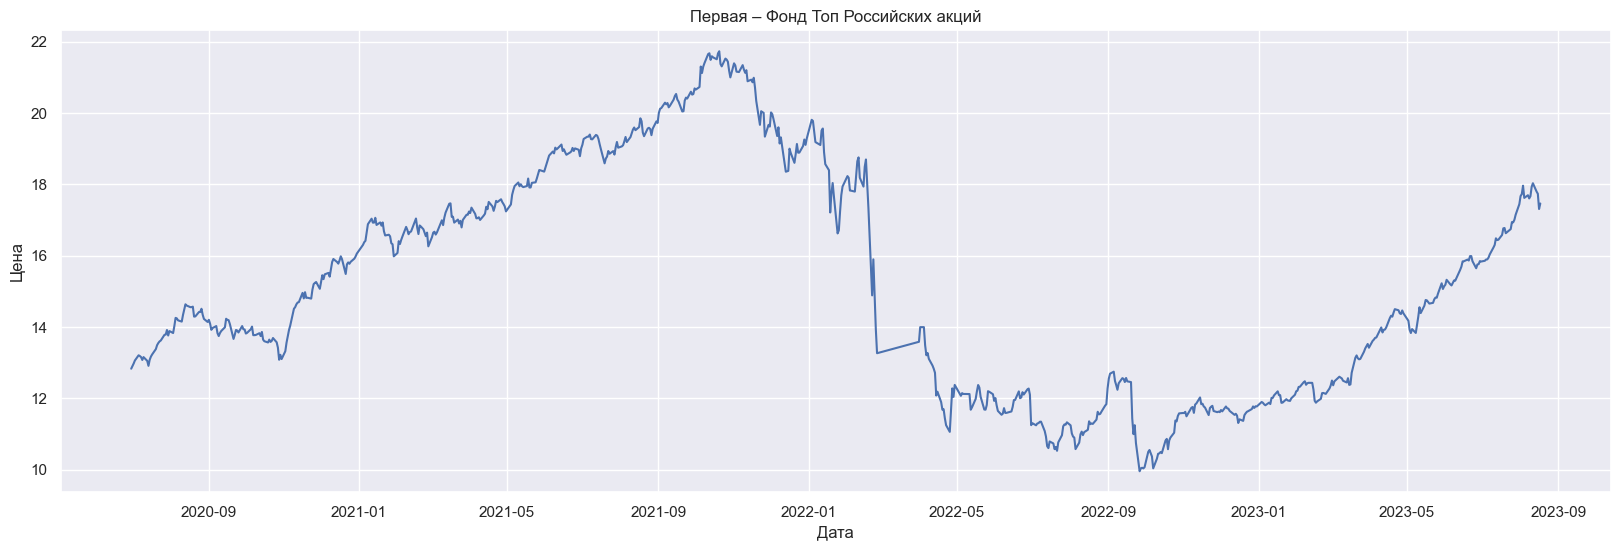

<function xticks at 0x00000265CAD508B0>


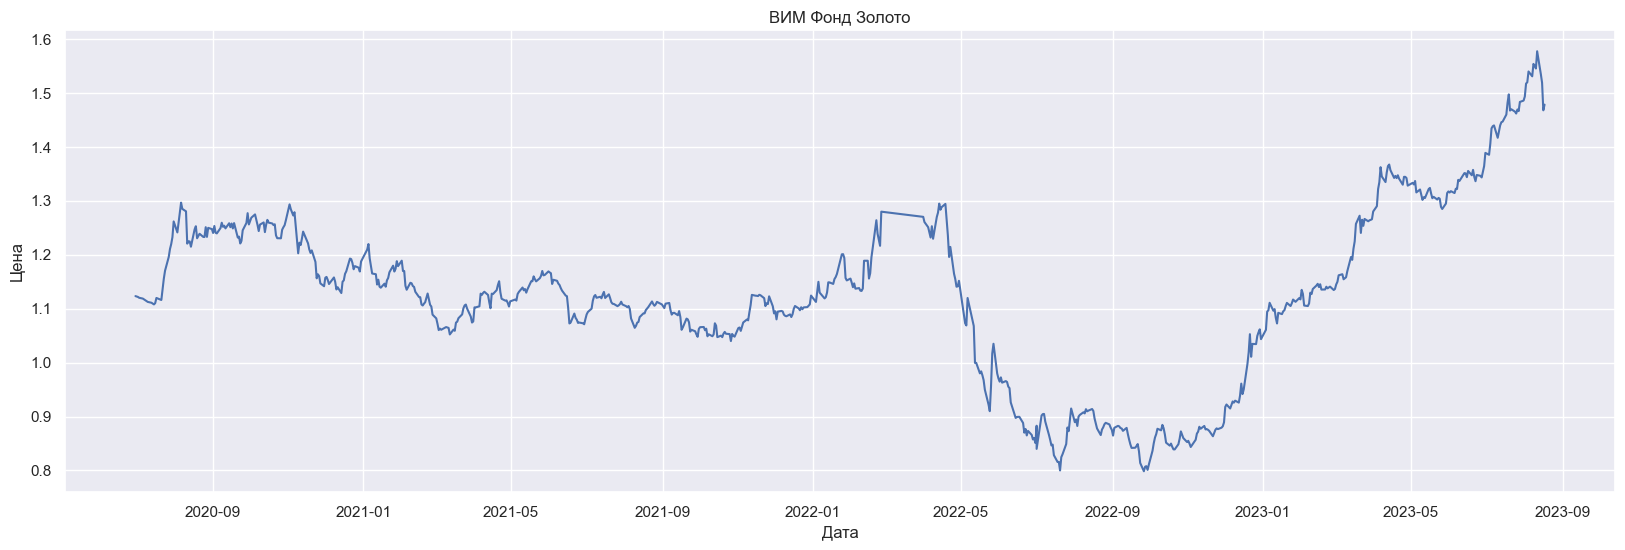

<function xticks at 0x00000265CAD508B0>


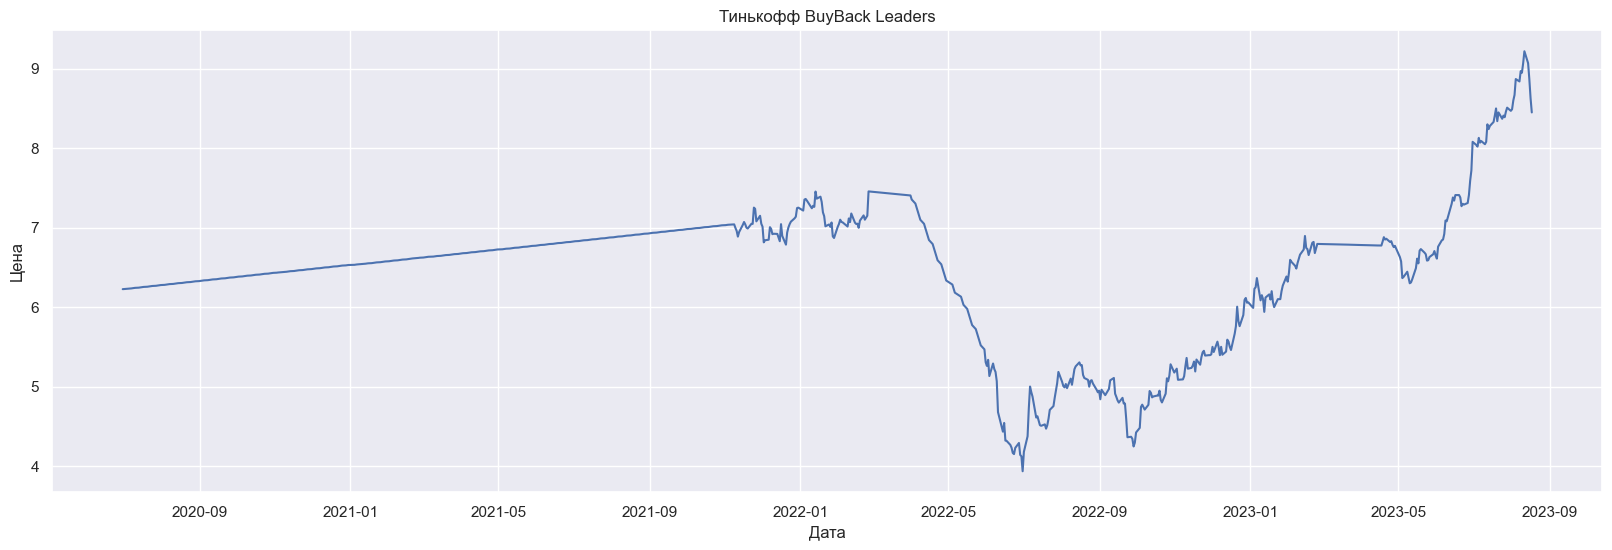

<function xticks at 0x00000265CAD508B0>


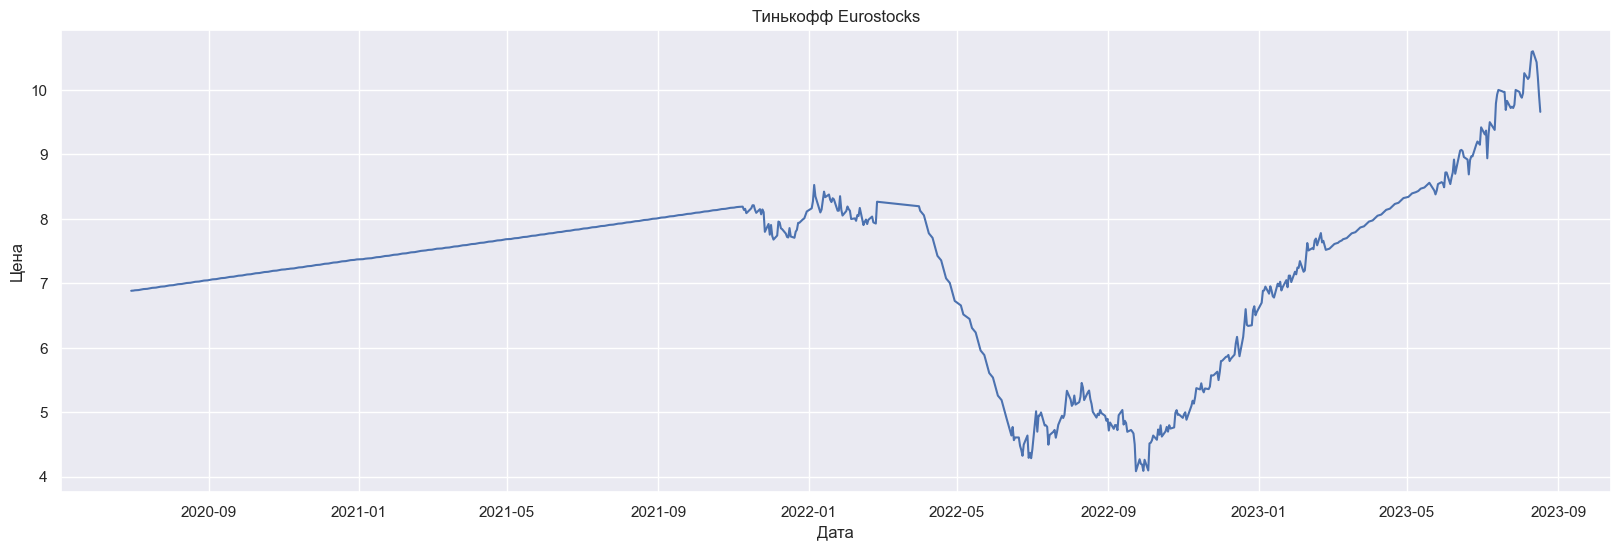

<function xticks at 0x00000265CAD508B0>


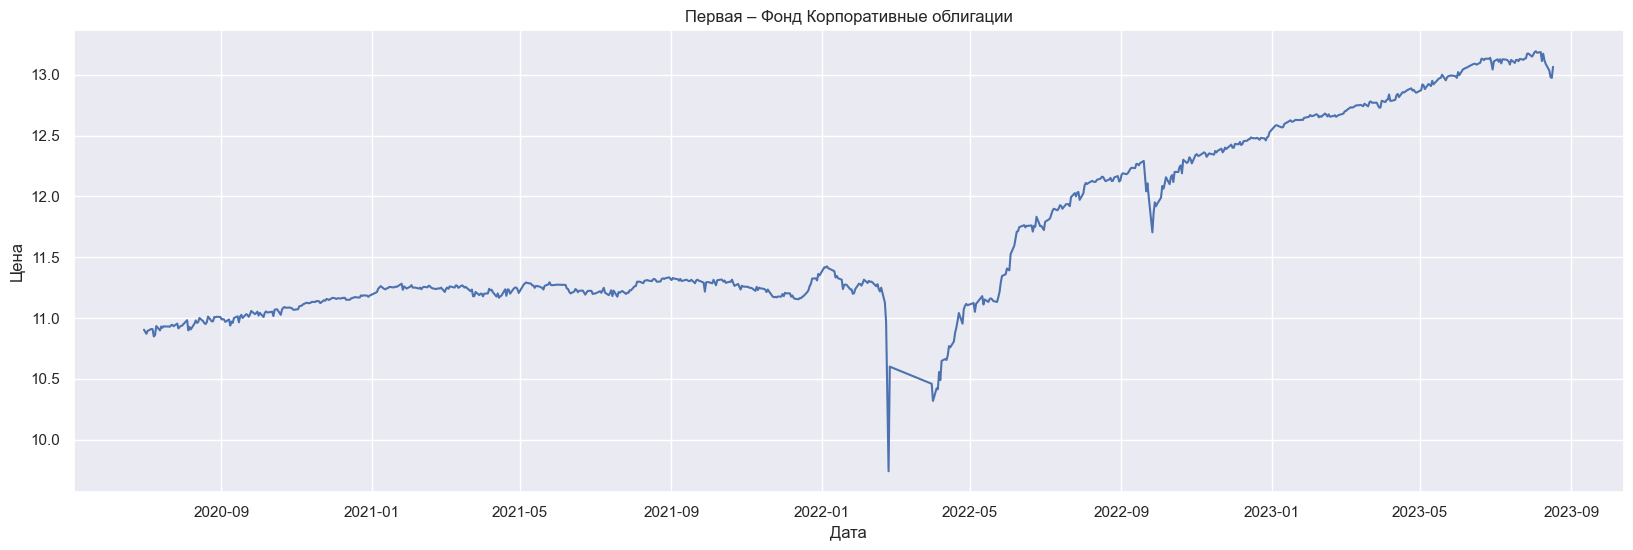

In [ ]:
def plot_asset(q, lock):
    while True:
        value = q.get()
        with lock:
            plt.figure(figsize=(20, 6))
            plt.plot(ans_df.time[:-1], ans_df[value][:-1])
            plt.title(value)
            plt.xlabel("Дата")
            plt.ylabel("Цена")
            print(plt.xticks)
            plt.show()
        q.task_done()


if __name__ == "__main__":
    q = Queue()
    lock = Lock()
    num_threads = 10
    for i in range(num_threads):
        thread = Thread(target=plot_asset, args=(q,lock))
        thread.daemon=True
        thread.start()

    for i in final_portfolio.columns[1:]:
        q.put(i)
    q.join()

# Оптимизации портфеля по Марковицу

In [ ]:
def get_coeff_by_return(ret, meanReturn, cov_matrix):
    
    size = meanReturn.shape[0]

    minimizeVolatility = lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    getReturns         = lambda w: np.sum(meanReturn * w)
    CheckSumOne        = lambda w: np.sum(w) - 1

    w0 = np.ones(size) / size
    
    bounds = tuple([(0, 1)]* size)

    constraints = ({"type":"eq", "fun":CheckSumOne}, 
                   {"type":"eq", "fun":lambda w: getReturns(w) - ret})
    
    opt = minimize(minimizeVolatility, w0,  method='SLSQP', bounds=bounds, constraints=constraints)
    return opt

In [ ]:
# функция, которая рисует стоимость портфеля по данным о стоимости активов
def plot_portfolio_wealth(final_portfolio, x, start, end):

    start_index = final_portfolio["time"].searchsorted(start.isoformat())
    end_index   = final_portfolio["time"].searchsorted(end.isoformat())

    start_sum = 1000

    plt.figure(figsize=(20, 6))
    plt.title(f"Динамика портфеля за промежуток данных c {start.date()}, по {end.date()}")
    plt.xlabel("Дата")
    plt.ylabel("Стоимость портфеля")

    returns = 1 +  final_portfolio.loc[start_index:end_index, :].drop(["time"], axis=1).pct_change()
    returns = np.cumprod(returns)
    plt.plot(final_portfolio.loc[start_index:end_index, :].time, np.dot(returns, x)*start_sum)

In [ ]:
# функция для построения границы эффективности для портфеля по Марковицу 
def findEfficientFrontier(meanReturn, expectedReturn, cov_matrix):
        
    returns_linspace = np.linspace(expectedReturn.min(), expectedReturn.max(), 50)

    volatility_opt = []
    for ret in returns_linspace:
        opt = get_coeff_by_return(ret, meanReturn, cov_matrix)
        volatility_opt.append(opt['fun'])
    
    volatility_opt = np.array(volatility_opt)
    
    return volatility_opt, returns_linspace

In [ ]:
# функция для нахождения максимального коэффициента Шарпа для портфеля
def findMaximumSharpRatio(meanReturn, cov_matrix, risk_free_rate):

    size = meanReturn.shape[0]
    
    def negativeSR(w):
        ret = np.sum(meanReturn * w)
        std = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        SharpRatio = (ret - risk_free_rate) / std
        return -1 * SharpRatio
    
    w0 = np.ones(size) / size
    
    bounds = tuple([(0, 1)]* size)
    
    constraints = ({"type":"eq", "fun":lambda x: np.sum(x) - 1})

    w_opt = minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    return w_opt.x, -1*w_opt['fun'], np.sqrt(np.dot(w_opt.x.T, np.dot(cov_matrix, w_opt.x)))

In [ ]:
# функция генерирует заданное число портфелей по методу Монте-Карло
def getRandomPortfolio(meanReturn, risk_free_rate,cov_matrix, portfolio_num = 10000):
    size = meanReturn.size
    # макссив весов портфелей
    weight = np.zeros((portfolio_num, size))
    
    # ожидаемая доходность по портфелям
    expectedReturn = np.zeros(portfolio_num)
    
    # ожидаемая волатильность по портфелям
    expectedVolatility = np.zeros(portfolio_num)
    
    # отношение шарпа по портфелям
    sharpRatio = np.zeros(portfolio_num)
    #np.random.seed(42)
    for k in range(portfolio_num):

        w = np.array(np.random.random(size))
        w = w / np.sum(w)
        weight[k, :] = w 
        
        expectedReturn[k]     = np.sum(meanReturn * w)
        expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpRatio[k]         = (expectedReturn[k] - risk_free_rate) / expectedVolatility[k]
        
    return expectedReturn, expectedVolatility, sharpRatio, weight

In [ ]:
def return_day_year(x):
    """
    перевод доходности из дневной в готовую в процентах
    """
    return ((x + 1) ** 252 - 1) 

In [ ]:
def return_year_day(x):
    return (x + 1)**(1/252) - 1


In [ ]:
# функция рисует границу эффективности по Марковицу для заданного портфеля
def plotEfficientFrontier(expectedVolatility,expectedReturn, sharpRatio, meanReturn, cov_matrix, col_name):
    
    size = meanReturn.size
    
    plt.subplots(figsize=(20, 6))
    
    volatility_opt, returns_linspace =  findEfficientFrontier(meanReturn, expectedReturn, cov_matrix)
    
    volatility_percent = volatility_opt * 100
    returns_linspace_year =  return_day_year(returns_linspace) * 100
    
    # отрисовка точки с минимальной волатильностью
    x = volatility_opt.argmin()
    y = returns_linspace_year[x]

    plt.annotate("min volatility", (volatility_percent[x], y),  xytext=(10,0), textcoords='offset points')
    plt.scatter(volatility_percent[x], y, c="blue")

    risk_free_rate = 0
    # отрисовка точки с максимальным коэффициентоа Шарпа
    opt, _, risk = findMaximumSharpRatio(meanReturn, cov_matrix, risk_free_rate)
    risk_percent = risk * 100
    returns_year = return_day_year(np.sum(meanReturn * opt)) * 100
    
    plt.annotate("max SR", (risk_percent, returns_year),  xytext=(10,0), textcoords='offset points')
    plt.scatter(risk_percent, returns_year, c="blue")

    # график сгенерированных портфелей
    pcm = plt.scatter(expectedVolatility * 100, return_day_year(expectedReturn)* 100, s=10, c=sharpRatio, alpha=0.8)
    
    plt.xlabel("Риск (стандартное отклонение), %")
    plt.ylabel("Ожидаемая доходность за год, %")
    plt.title("Оптимизация портфеля по Марковицу")

    ans = []
    # наношу доходности активов на график
    for i in range(size):
        tmp = np.zeros(size)
        tmp[i] = 1
        V =  100* np.sqrt(np.dot(tmp.T, np.dot(cov_matrix, tmp)))
        R = return_day_year(np.sum(meanReturn * tmp)) * 100
        ans += [[V, R]]
        plt.annotate(col_name[i], (V, R),  xytext=(10,0), textcoords='offset points')

    ans = np.array(ans)
    # оптимальная поверхность
    plt.plot(volatility_percent, returns_linspace_year, '--')

    # рисуем точки-активы
    plt.scatter(ans[:, 0], ans[:, 1],  marker='o', s=100, c='blue', edgecolors='black' )
    plt.colorbar(pcm, label='Коэффициент Шарпа')
    
    plt.show()

In [ ]:
port = final_portfolio.drop(['time'], axis=1)
port

,Первая – Фонд Топ Российских акций,ВИМ Фонд Золото,Тинькофф BuyBack Leaders,Тинькофф Eurostocks,Первая – Фонд Корпоративные облигации
0,12.835,1.123413,6.225703,6.884951,10.904
1,12.980,1.121871,6.228059,6.888723,10.870
2,13.065,1.120330,6.230415,6.892494,10.894
3,13.210,1.118789,6.232772,6.896266,10.910
4,13.190,1.117248,6.235128,6.900038,10.908
...,...,...,...,...,...
769,17.800,1.535000,9.070000,10.430000,13.034
770,17.739,1.519000,8.870000,10.200000,12.979
771,17.312,1.468000,8.630000,9.910000,12.974
772,17.466,1.478500,8.450000,9.660000,13.065


**Определение весов активов в портфеле по загруженным данным**

------------------------  Загразка данных  -------------------------
--------------------------------------------------------------------
Максимальное отношение Шарпа: 0.06, доходность 0.037% в день
--------------------------------------------------------------------
Коэффициенты для максимального отношения шарпа: 
Первая – Фонд Топ Российских акций     0.14
ВИМ Фонд Золото                        0.12
Тинькофф BuyBack Leaders               0.12
Тинькофф Eurostocks                    0.11
Первая – Фонд Корпоративные облигации  0.51
--------------------------------------------------------------------
--------------------------------------------------------------------
Коэффициенты для доходности: 13.0%
Первая – Фонд Топ Российских акций     0.32
ВИМ Фонд Золото                        0.2
Тинькофф BuyBack Leaders               0.18
Тинькофф Eurostocks                    0.23
Первая – Фонд Корпоративные облигации  0.07
--------------------------------------------------------------------


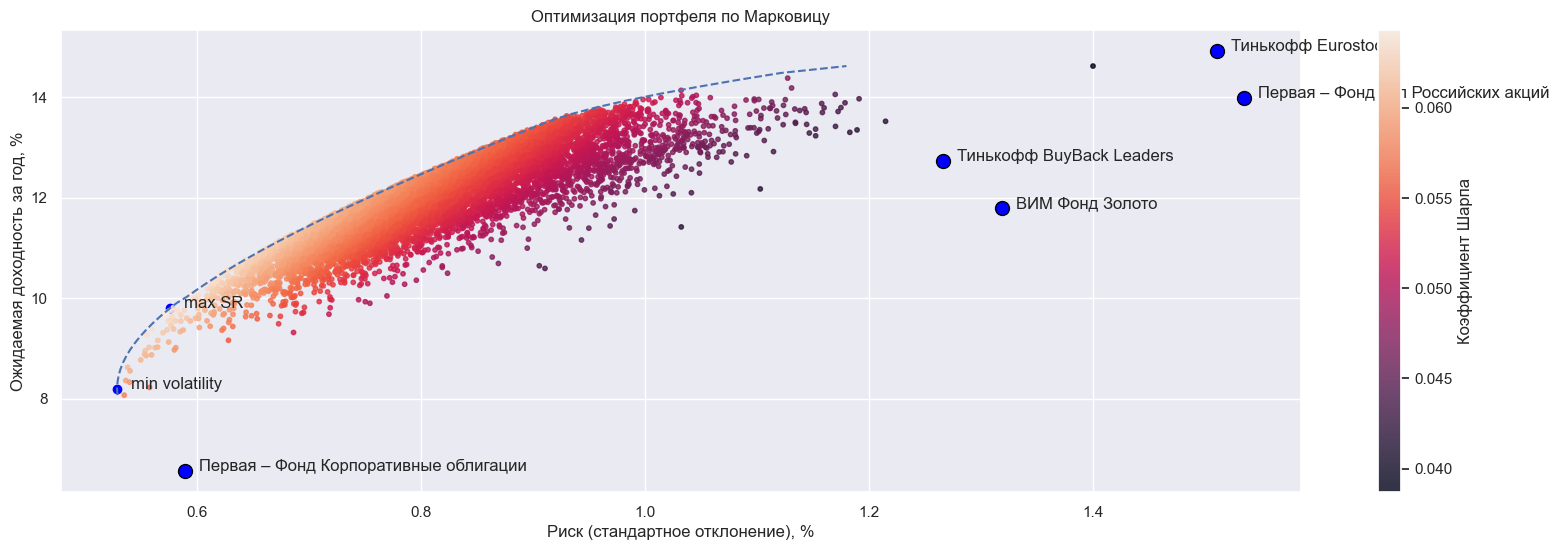

In [ ]:
# скачивание информации по тикерам за выбранные промежутки
print("-"*24, " Загразка данных ", "-"*25)
#stocks = yf.download(col_name, start, end).Close
stocks = port[:-1]
print("-"*68)

stocks = stocks.dropna()
risk_free_rate = 0.00

# доходность по каждой бумаге
returns    = stocks.pct_change()
# матрица коварианций
cov_matrix = returns.cov()
# усредненный доход по каждой бумеге
meanReturn = returns.mean()


opt, SR, risk = findMaximumSharpRatio(meanReturn, cov_matrix, risk_free_rate)

print(f"Максимальное отношение Шарпа: {np.round(SR, 2)}, доходность {np.round(np.sum(meanReturn*opt), 5)*100}% в день")
print("-"*68)
print("Коэффициенты для максимального отношения шарпа: ")
ans = np.vstack((port.columns, np.round(opt, 2)))
results = tabulate.tabulate(ans.T,tablefmt= "plain")
print(results)
print("-"*68)

p = 0.13
opt = get_coeff_by_return(return_year_day(p), meanReturn, cov_matrix).x

print("-"*68)
print(f"Коэффициенты для доходности: {100* p}%")

ans = np.vstack((port.columns, np.round(opt, 2)))
results = tabulate.tabulate(ans.T,tablefmt= "plain")
print(results)
print("-"*68)


expectedReturn, expectedVolatility, sharpRatio, _ =  getRandomPortfolio(meanReturn,
                                                                        risk_free_rate, cov_matrix, 
                                                                        portfolio_num=10000)


plotEfficientFrontier(expectedVolatility,expectedReturn, sharpRatio,meanReturn,cov_matrix, port.columns )

# Общая информация о потрфеле

**Окончательная стратегия для инвестирования на 7/21/2023**

| Фонд                                  | Коэффициент |
|---------------------------------------|-------------|
| Фонд Топ Российских акций             | 0.2       |
| ВИМ Фонд Золото                        | 0.2        |
| Тинькофф BuyBack Leaders               | 0.22      |
| Тинькофф Eurostocks                    | 0.27        |
| Фонд Корпоративные облигации           | 0.12       |

Коэффициенты для доходности: 13.0%